In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import defaultdict

%matplotlib inline

In [2]:
%config Completer.use_jedi = False

In [3]:
train = pd.read_csv("/Users/sergmiller/Downloads/train.csv")
edu = pd.read_csv("/Users/sergmiller/Downloads/trainEducationFeatures.csv")
groups =  pd.read_csv("/Users/sergmiller/Downloads/trainGroups.csv")
friends =  pd.read_csv("/Users/sergmiller/Downloads/friends.csv")

In [4]:
np.mean(train['registered_year'])

2013.7580508330789

In [5]:
np.corrcoef(train['registered_year'].values, train['age'].values)

array([[ 1.        , -0.09645648],
       [-0.09645648,  1.        ]])

(array([ 215., 1516., 5647., 3314., 4802., 1981., 3671., 1731., 3629.,
        2963.]),
 array([2006. , 2007.5, 2009. , 2010.5, 2012. , 2013.5, 2015. , 2016.5,
        2018. , 2019.5, 2021. ]),
 <BarContainer object of 10 artists>)

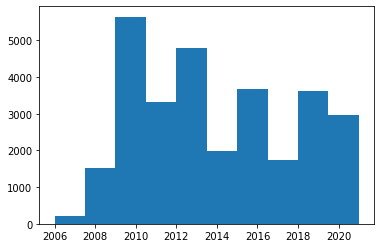

In [6]:
plt.hist(train['registered_year'])

In [7]:
from sklearn.linear_model import LinearRegression

In [158]:
max(train['age'])

89

In [176]:
edu.shape, train.shape

((29469, 9), (29469, 3))

In [8]:
edu_with_register = pd.merge(edu[~pd.isnull(edu['school_education'])], train, how='left', on='uid')

In [9]:
edu_with_register

,uid,school_education,graduation_1,graduation_2,graduation_3,graduation_4,graduation_5,graduation_6,graduation_7,age,registered_year
0,30288,2008.0,NaN,NaN,NaN,NaN,2013.0,NaN,NaN,30,2008
1,25275,2007.0,NaN,NaN,NaN,NaN,NaN,2011.0,NaN,31,2007
2,116156,2008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,2010
3,10794,2006.0,NaN,NaN,NaN,NaN,NaN,NaN,2014.0,34,2010
4,99780,1995.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,2012
...,...,...,...,...,...,...,...,...,...,...,...
9109,90272,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,2012
9110,33331,1987.0,NaN,NaN,NaN,NaN,1991.0,NaN,NaN,51,2008
9111,97581,2002.0,NaN,NaN,NaN,NaN,2007.0,NaN,NaN,36,2010
9112,104038,1969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,2013


In [10]:
edu_with_g5 = pd.merge(edu[~pd.isnull(edu['graduation_5'])], train, how='left', on='uid')

In [11]:
edu_with_g5_and_reg = pd.merge(edu[~pd.isnull(edu['graduation_5'])][~pd.isnull(edu['school_education'])], train, how='left', on='uid')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [419]:
edu_with_g5_and_reg.shape

(1268, 11)

In [420]:
model = LinearRegression()
model.fit(edu_with_g5_and_reg[['registered_year', 'school_education', 'graduation_5']], edu_with_g5_and_reg['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([ 0.06561199, -0.82945563, -0.12746959]), 1821.0781979242786)

In [415]:
model = LinearRegression()
model.fit(edu_with_g5[['registered_year', 'graduation_5']], edu_with_g5['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([ 0.2681817 , -0.89100903]), 1287.6021512433363)

In [184]:
model = LinearRegression()
model.fit(edu_with_register[['registered_year', 'school_education']], edu_with_register['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([-0.05582762, -0.88421684]), 1918.9770112931192)

In [196]:
model = LinearRegression()
model.fit(edu_with_register[['school_education']], edu_with_register['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([-0.88518542]), 1808.6193469773386)

In [105]:
model = LinearRegression()
model.fit(train[['registered_year', 'school']], train['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([-0.32882735]), 697.2078772973922)

In [ ]:
model.predict()

In [12]:
def decision(school: float, register: float, groups: list):
    if np.isnan(school):
        r = 697.208 - 0.32883 * register  # approx 35
    else:
#         r = 2021 - school + 18
        r = 1918.977 - 0.05583 * register - 0.88422 * school
#         r = 1808.62 - 0.88519 * school
    r = max(r, 14)
    r = min(89, r)
    return r


def make_predictions(ids: pd.DataFrame, education: pd.DataFrame, groups: pd.DataFrame) -> pd.DataFrame:
    result = pd.DataFrame()
    result['uid'] = ids['uid']
    school = {uid : year for uid, year in zip(education['uid'].values, education['school_education'].values)}
    register = {uid : year for uid, year in zip(ids['uid'].values, ids['registered_year'].values)}
    groups_list = defaultdict(list)
    for uid, gid in zip(groups['uid'].values, groups['gid'].values):
        groups_list[uid].append(gid)
    result['age'] = [decision(school[uid], register[uid], groups_list[uid]) for uid in result['uid'].values]
    assert result.shape[0] == ids.shape[0] and result.shape[1] == 2
    assert ['uid', 'age'] == list(result.columns)
    return result

In [364]:
res = make_predictions(train, edu, groups)

In [360]:
np.mean((res['age'] - train['age']) ** 2) ** 0.5

11.541098370410738

In [19]:
result.to_csv('/Users/sergmiller/Downloads/result.csv', index=None, index_label=None)

In [23]:
np.mean(train['age'].values)

35.02914927550986

In [17]:
list(result.columns)

['uid', 'age']

In [ ]:
np.mean(train['age'].values)

In [13]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

In [14]:
user_weights = groups.groupby('uid').gid.nunique()
user2weight = {u:w for u,w in zip(user_weights.index.values, user_weights.values)}

In [15]:
row = groups['gid'].values
col = groups['uid'].values
data = [user2weight[u] for u in col]

(array([1.784e+03, 1.130e+03, 8.550e+02, 7.280e+02, 7.080e+02, 6.500e+02,
        6.140e+02, 5.250e+02, 5.000e+02, 5.270e+02, 4.330e+02, 4.150e+02,
        2.970e+02, 4.240e+02, 3.910e+02, 3.470e+02, 3.270e+02, 3.050e+02,
        2.900e+02, 3.050e+02, 2.970e+02, 3.000e+02, 2.530e+02, 2.820e+02,
        1.690e+02, 2.260e+02, 2.400e+02, 2.170e+02, 2.520e+02, 2.020e+02,
        1.840e+02, 1.850e+02, 2.000e+02, 6.029e+03, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,   3.92,   6.84,   9.76,  12.68,  15.6 ,  18.52,  21.44,
         24.36,  27.28,  30.2 ,  33.12,  36.04,  38.96,  41.88,  44.8 ,
         47.72,  50.64,  53.56,  56.48,  59.4 ,  62.32,  65.24,  68.16,
         71.08,  74.  ,  76.92,  79.84,  82.76,  85.68,  88.6 ,  91.52,
         94.44,  97.36, 100.28, 103.2 , 106.12, 109.04, 111.96, 114.88,
        117.8 , 

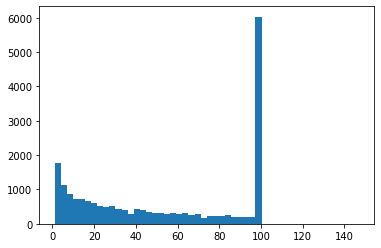

In [16]:
plt.hist(user_weights.values, bins=50)

In [17]:
max(row), max(col)

(362032, 120055)

In [18]:
train_g2u = csr_matrix((data, (row, col)), shape=(362033, 120056))

In [19]:
als = AlternatingLeastSquares(factors=32, random_state=0)
als.fit(train_g2u)

  0%|          | 0/15 [00:00<?, ?it/s]

In [308]:
als.item_factors.shape

(362033, 32)

In [309]:
als.user_factors.shape

(120056, 32)

In [20]:
from sklearn.neighbors import KNeighborsRegressor

In [311]:
N = 10000

In [312]:
user_embs_for_knn = np.array([als.user_factors[u] for u in train['uid'].values])
knn_age = train['age'].values
user_embs_for_knn.shape, knn_age.shape

((29469, 32), (29469,))

In [21]:
def calc_embedding_by_user_groups(user_groups: np.array):
    groups_embeds = als.item_factors[user_groups]
    user_embed = np.mean(groups_embeds, axis=0)
    return user_embed

In [351]:
%%time
for x in user_embs_for_knn[N:]:
    print(float(knn.predict([x])))
    break

31.426724404225716
CPU times: user 6.27 ms, sys: 2.66 ms, total: 8.93 ms
Wall time: 2.73 ms


In [376]:
%%time
knn = KNeighborsRegressor(weights='distance', n_neighbors=25)
knn.fit(user_embs_for_knn, knn_age)

knn_age_predicted = knn.predict(user_embs_for_knn)

res = np.mean((knn_age_predicted - knn_age) ** 2) ** 0.5
res

CPU times: user 28.7 s, sys: 7.59 s, total: 36.3 s
Wall time: 16.7 s


7.627103383099767

In [344]:
%%time
knn = KNeighborsRegressor(weights='distance', n_neighbors=25)
knn.fit(user_embs_for_knn[:N], knn_age[:N])

knn_age_predicted = knn.predict(user_embs_for_knn[N:])

res = np.mean((knn_age_predicted - knn_age[N:]) ** 2) ** 0.5
res

CPU times: user 6.41 s, sys: 1.9 s, total: 8.32 s
Wall time: 3.66 s


10.719051118447588

In [348]:
pd.read_csv('../submision/data/train_groups.csv').values.shape

(160831, 1)

In [326]:
known_groups = np.unique(groups['gid'].values)

In [329]:
pd.DataFrame(known_groups).to_csv("../submision/data/train_groups.csv", index=None, index_label=None)

In [330]:
user_embs_for_knn.shape

(29469, 32)

In [331]:
train['uid'].shape

(29469,)

In [332]:
pd.DataFrame(train).to_csv("../submision/data/train.csv", index=None, index_label=None)

In [336]:
pd.DataFrame(user_embs_for_knn).to_csv("../submision/data/train_als_user_embeddings.csv", index=None, index_label=None)

In [340]:
group_embds_for_knn = als.item_factors[known_groups]

In [341]:
group_embds_for_knn.shape

(160831, 32)

In [339]:
user_embs_for_knn.shape

(29469, 32)

In [342]:
pd.DataFrame(group_embds_for_knn).to_csv("../submision/data/train_als_group_embeddings.csv", index=None, index_label=None)

In [345]:
als.item_factors[[1,2]]

array([[-0.03352285,  0.01173679, -0.00479133, -0.00079793,  0.00691519,
         0.02763588, -0.00387738, -0.02486044, -0.00412413, -0.01828809,
         0.03304713,  0.00094347,  0.03785113, -0.00548973,  0.00034857,
        -0.02208665,  0.00284895,  0.03267703, -0.00689618,  0.02914728,
         0.01545629,  0.01312421,  0.01298617,  0.01491231, -0.01607238,
        -0.00461709, -0.00313677,  0.00893403,  0.01912749,  0.04901997,
        -0.00721672,  0.02671472],
       [ 0.01577521, -0.00342512, -0.03403663, -0.00619824, -0.01844874,
         0.02002376, -0.01083123, -0.01982027, -0.02211998,  0.02357365,
         0.02775149,  0.00207958,  0.00818852,  0.0136739 ,  0.01661555,
         0.00561788, -0.01665961, -0.01122996, -0.00927404, -0.0091855 ,
         0.01583714,  0.01119312,  0.01644872, -0.00017456,  0.01745618,
         0.00827894,  0.00624486,  0.00029817,  0.00274924,  0.02194361,
         0.00729352,  0.02449917]], dtype=float32)

In [368]:
pd.read_csv('../submision/data/train_als_user_embeddings.csv').values

array([[ 0.00620317,  0.01065773, -0.01442813, ...,  0.02823488,
         0.02111417,  0.0143768 ],
       [ 0.6269256 , -0.19519456,  0.26703796, ...,  0.19338019,
         0.8778059 , -0.30893627],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02584702,  0.06221347, -0.00454262, ...,  0.01528523,
         0.01898878,  0.09596544],
       [-0.5718822 ,  0.6594821 ,  0.07554404, ..., -1.6461611 ,
         0.64993376, -1.061764  ]])

In [22]:
friends2way = pd.DataFrame()
friends2way['uid'] = list(friends['uid']) + list(friends['fuid'])
friends2way['fuid'] = list(friends['fuid']) + list(friends['uid'])

In [23]:
friends2way.shape

(8219754, 2)

In [24]:
friend_weights = friends2way.groupby('uid').fuid.nunique()
friend2weight = {u:w for u,w in zip(friend_weights.index.values, friend_weights.values)}

In [25]:
rowf = friends2way['fuid'].values
colf = friends2way['uid'].values
dataf = [friend2weight[u] for u in colf]

(array([7.1364e+04, 2.3933e+04, 1.0380e+04, 2.4480e+03, 6.8500e+02,
        3.7100e+02, 2.3300e+02, 2.0600e+02, 1.2700e+02, 9.4000e+01,
        7.8000e+01, 7.3000e+01, 5.8000e+01, 4.5000e+01, 4.2000e+01,
        2.8000e+01, 2.4000e+01, 2.2000e+01, 1.4000e+01, 1.2000e+01,
        2.1000e+01, 7.0000e+00, 1.0000e+01, 1.0000e+01, 1.0000e+01,
        7.0000e+00, 3.0000e+00, 6.0000e+00, 5.0000e+00, 4.0000e+00,
        3.0000e+00, 3.0000e+00, 5.0000e+00, 2.0000e+00, 1.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([1.00000e+00, 5.55200e+01, 1.10040e+02, 1.64560e+02, 2.19080e+02,
        2.73600e+02, 3.28120e+02, 3.82640e+02, 4.37160e+02, 4.91680e+02,
        5.46200e+02, 6.00720e+02, 6.55240e+02, 7.09760e+02, 7.64280e+02,
        8.18800e+02, 8.73320e+02, 9.27840e+02, 9.82360e+02, 1.03688e+03,
        1.09140e+03, 1.145

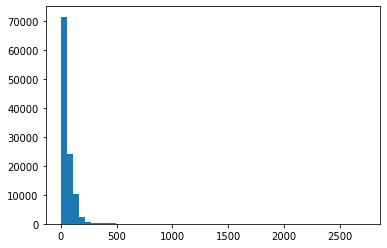

In [26]:
plt.hist(friend_weights.values, bins=50)

In [27]:
max(rowf), max(colf)

(120060, 120060)

In [28]:
train_f2u = csr_matrix((dataf, (rowf, colf)), shape=(120061, 120061))

In [29]:
friends_als = AlternatingLeastSquares(factors=16, random_state=0)
friends_als.fit(train_f2u)

  0%|          | 0/15 [00:00<?, ?it/s]

In [394]:
als.item_factors.shape

(120061, 16)

In [395]:
als.user_factors.shape

(120061, 16)

In [396]:
from sklearn.neighbors import KNeighborsRegressor

In [397]:
N = 10000

In [398]:
user_embs_for_knn = np.array([als.user_factors[u] for u in train['uid'].values])
knn_age = train['age'].values
user_embs_for_knn.shape, knn_age.shape

((29469, 16), (29469,))

In [399]:
def calc_embedding_by_user_friends(user_friends: np.array):
    groups_embeds = als.item_factors[user_friends]
    user_embed = np.mean(groups_embeds, axis=0)
    return user_embed

In [351]:
%%time
for x in user_embs_for_knn[N:]:
    print(float(knn.predict([x])))
    break

31.426724404225716
CPU times: user 6.27 ms, sys: 2.66 ms, total: 8.93 ms
Wall time: 2.73 ms


In [400]:
%%time
knn = KNeighborsRegressor(weights='distance', n_neighbors=25)
knn.fit(user_embs_for_knn, knn_age)

knn_age_predicted = knn.predict(user_embs_for_knn)

res = np.mean((knn_age_predicted - knn_age) ** 2) ** 0.5
res

CPU times: user 29.5 s, sys: 6.69 s, total: 36.1 s
Wall time: 17.5 s


4.1398631323867425

In [403]:
%%time

for ng in [5,10,15,20,25,50,100]:
    knn = KNeighborsRegressor(weights='distance', n_neighbors=ng)
    knn.fit(user_embs_for_knn[:N], knn_age[:N])

    knn_age_predicted = knn.predict(user_embs_for_knn[N:])

    res = np.mean((knn_age_predicted - knn_age[N:]) ** 2) ** 0.5
    print(ng, res)

5 10.627967069866244
10 10.174975948579815
15 10.13221329894644
20 10.093566655497026
25 10.090185866004456
50 10.145900310413072
100 10.230385974242639
CPU times: user 49.6 s, sys: 12.6 s, total: 1min 2s
Wall time: 31.3 s


In [134]:
known_friends = np.unique(friends2way['uid'].values)

In [405]:
pd.DataFrame(known_friends).to_csv("../submision/data/train_friends.csv", index=None, index_label=None)

In [139]:
friends_user_embds_for_knn = friends_als.item_factors[known_friends]
friends_train_user_embs_for_knn = np.array([friends_als.user_factors[u] for u in train['uid'].values])

In [141]:
pd.DataFrame(friends_train_user_embs_for_knn).to_csv("../submision/data/train_friends_als_user_embeddings.csv", index=None, index_label=None)
pd.DataFrame(friends_user_embds_for_knn).to_csv("../submision/data/friends_als_user_embeddings.csv", index=None, index_label=None)

In [407]:
friends_embds_for_knn = als.item_factors[known_friends]

In [408]:
pd.DataFrame(friends_embds_for_knn).to_csv("../submision/data/train_friends_als_friends_embeddings.csv", index=None, index_label=None)

In [145]:
from sklearn.neural_network import MLPRegressor

In [31]:
uid2age =  {u:a for u,a in zip (train['uid'].values, train['age'].values)}

In [36]:
from fast_pagerank import pagerank_power

In [42]:
friend_pr=pagerank_power(train_f2u, p=0.85, tol=1e-3)

In [43]:
friend_pr

array([3.27044627e-06, 2.52198502e-05, 1.34158138e-06, ...,
       1.38165961e-06, 1.34158138e-06, 1.59154157e-05])

In [99]:
friends_list = defaultdict(list)
for uid, fuid in zip(friends['uid'].values, friends['fuid'].values):
    friends_list[uid].append(fuid)
    friends_list[fuid].append(uid)

In [128]:
f_cache = {}
def get_friends_mean_embed(uid):
    if uid in f_cache:
        return f_cache[uid]
    e = np.zeros(16)
    f_list = friends_list[uid]
    if len(f_list) == 0:
        return e
    for f in f_list:
        e += friends_als.user_factors[f]
    r = e / len(f_list)
    f_cache[uid] = r
    return r

In [150]:
def decision_naive_impl(school: float, register: float, g5: float) -> float:
    if np.isnan(school):
        if np.isnan(g5):
            r = 697.208 - 0.32883 * register  # LM approx 35
        else:
            r = 1287.602 + 0.26818 * register - 0.89101 * g5  # LM approx register and graduation_5
    else:
        if np.isnan(g5):
            r = 1918.977 - 0.05583 * register - 0.88422 * school  # LM approx 2021 - school + 18 + Residual(register)
        else:
            r = 1821.079 + 0.06561 * register - 0.82946 * school - 0.12747 * g5  # LM approx all available params
    r = max(14, r)
    r = min(89, r)
    return r

In [193]:
import networkx as nx

In [195]:
g = nx.Graph()

for st in friends_list.keys():
    for fn in friends_list[st]:
        g.add_edge(st, fn)

In [197]:
numNodes = len(g.nodes)
numNodes

110352

In [228]:
import networkx as nx
import numpy as np
import scipy
from scipy.sparse import csgraph

numNodes = len(g.nodes)
degreeHist = nx.degree_histogram(g)
degreeKernel = [x/numNodes for x in degreeHist]

In [218]:
A = nx.convert_matrix.to_scipy_sparse_matrix(g)

In [214]:
X = np.zeros((110352, 19))

id2node = {_id: i for i, _id in enumerate(list(g.nodes))}

for i,uid in enumerate(list(g.nodes)):
    X[i] = [
        friend2weight.get(uid, 0),
        user2weight.get(uid, 0),
        friend_pr[uid]
    ] + list(friends_als.user_factors[uid])

In [251]:
W0 = np.random.normal(size=(19, 16)) / 2 * (16 ** 0.5)
W1 = np.random.normal(size=(19 + 16, 16)) / 2 * (16 + 16) ** 0.5
W2 = np.random.normal(size=(19 + 16 + 16, 16)) / 2 * (19 + 16 + 16) ** 0.5

In [252]:
D = scipy.sparse.csgraph.laplacian(A, normed=True)
# слой 0
Xc = D @ X @ W0
# ReLU
Xc = Xc * (Xc>0)
# конкатенация признаков вершин с аггрегированной информацией соседей
Xn = np.hstack((X, Xc))
# слой 1
Xc = D @ Xn @ W1
# ReLU
Xc = Xc * (Xc>0)
Xn = np.hstack((Xn, Xc))
# слой 2 - эмбеддинги вершин
Xc = D @ Xn @ W2

embedding = Xc / Xc.sum(axis=1, keepdims=True)

In [264]:
pd.DataFrame(list(g.nodes)).to_csv('../submision/data/graph_nodes_user_ids.csv', index=None, index_label=None)
pd.DataFrame(embedding).to_csv('../submision/data/graph_embeddings.csv', index=None, index_label=None)

In [253]:
uid2gembeddding = {uid: embedding[i] for i, uid in enumerate(list(g.nodes))}

In [271]:
edu_features = []
edu_ids = edu['uid']
edu_ages = np.array([uid2age[u] for u in edu_ids])
uid2register = {u:r for u,r in zip(train['uid'].values, train['registered_year'].values)}
for x in edu.iterrows():
    x = x[1]
    uid = int(x['uid'])
    get_2000 = lambda name: x[name] - 2000 if not np.isnan(x[name]) else 0
    make_ind = lambda name: float(np.isnan(x[name]))
    features_ind = [make_ind('school_education')]
    for i in range(1, 8):
        features_ind.append(make_ind('graduation_{}'.format(i)))
    features = [get_2000('school_education')]
    for i in range(1, 8):
        features.append(get_2000('graduation_{}'.format(i)))
    register_year = uid2register[uid]
    
    features.append(friend2weight.get(uid, 0))
    features.append(user2weight.get(uid, 0))
    features.append(friend_pr[uid])
#     features.append(register_year)
#     features.append(decision_naive_impl(x['school_education'], register_year, x['graduation_5']))
    f = features_ind + features + list(uid2gembeddding.get(uid, np.zeros(16))) + list(als.user_factors[uid])  # + list(get_friends_mean_embed(uid))
#     f += list(uid2gembeddding.get(uid, np.zeros(16)))
    edu_features.append(f)

In [272]:
GROUP_ALS_DIM = 32
FRIEND_ALS_DIM = 16
ALS_TRAIN_GROUPS_TH = 1  # 5 is worse that 1
GROUP_OVER_FRIEND_WEIGHT = 0.75
ALS_OVER_NAIVE_WEIGHT = 0.5
# NAIVE_OVER_CB_WEIGHT = 0
# FRIEND_ALS_OVER_CB_WEIGHT = 0
FULL_ALS_OVER_CB_WEIGHT = 0.5

CB_V1_FEATURE_COUNT = 8 + 8 + 2 + 1 + 16
CB_V2_FEATURE_COUNT = CB_V1_FEATURE_COUNT  # + FRIEND_ALS_DIM
CB_V3_FEATURE_COUNT = CB_V2_FEATURE_COUNT + GROUP_ALS_DIM

In [105]:
len(edu_features[0]), 32 + 16 + 8 + 8 + 2 + 1 + 16

(83, 83)

In [146]:
model = MLPRegressor(hidden_layer_sizes=(32, 32, 32), random_state=0)

In [147]:
model.fit(edu_features[:K], edu_ages[:K])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(hidden_layer_sizes=(32, 32, 32), random_state=0)

In [148]:
predict = model.predict(edu_features[K:])

In [149]:
np.mean((predict - edu_ages[K:]) ** 2) ** 0.5

8.516170490454353

In [106]:
import catboost

In [183]:
model = catboost.CatBoostRegressor(random_state=0, n_estimators=10000)

In [269]:
edu_features.shape

(29469, 83)

In [273]:
edu_features = np.array(edu_features)
M = len(edu_features)
ids = np.arange(M)
np.random.seed(0)
np.random.shuffle(ids)
K = 25000
train_ids = ids[:K]
val_ids = ids[K:]
print(train_ids, val_ids, K, M)

[ 5323  2124 13065 ... 24015  9191 14056] [ 3836  8618  7370 ...  9845 10799  2732] 25000 29469


In [274]:
%%time
model1 = catboost.CatBoostRegressor(random_state=0)
model1.fit(edu_features[train_ids, :CB_V1_FEATURE_COUNT], edu_ages[train_ids],
           eval_set=(edu_features[val_ids, :CB_V1_FEATURE_COUNT], edu_ages[val_ids]))

model1.save_model("../submision/data/edu_v1_g_mini.cbm")

# model2 = catboost.CatBoostRegressor(random_state=0, n_estimators=10000)
# model2.fit(edu_features[train_ids, :CB_V2_FEATURE_COUNT], edu_ages[train_ids],
#            eval_set=(edu_features[val_ids, :CB_V2_FEATURE_COUNT], edu_ages[val_ids]))

# model2.save_model("../submision/data/edu_v2_g_10K.cbm")

model3 = catboost.CatBoostRegressor(random_state=0, n_estimators=10000)
model3.fit(edu_features[train_ids, :CB_V3_FEATURE_COUNT], edu_ages[train_ids],
           eval_set=(edu_features[val_ids, :CB_V3_FEATURE_COUNT], edu_ages[val_ids]))

model3.save_model("../submision/data/edu_v3_g_mini_10K.cbm")

Learning rate set to 0.084664
0:	learn: 12.8592568	test: 12.8971152	best: 12.8971152 (0)	total: 8.72ms	remaining: 8.71s
1:	learn: 12.6381611	test: 12.6692587	best: 12.6692587 (1)	total: 14.2ms	remaining: 7.08s
2:	learn: 12.4323378	test: 12.4525871	best: 12.4525871 (2)	total: 19.4ms	remaining: 6.45s
3:	learn: 12.2624849	test: 12.2780128	best: 12.2780128 (3)	total: 23.4ms	remaining: 5.82s
4:	learn: 12.1085889	test: 12.1207680	best: 12.1207680 (4)	total: 26.8ms	remaining: 5.33s
5:	learn: 11.9674683	test: 11.9733543	best: 11.9733543 (5)	total: 30.5ms	remaining: 5.05s
6:	learn: 11.8448107	test: 11.8481456	best: 11.8481456 (6)	total: 34ms	remaining: 4.83s
7:	learn: 11.7341031	test: 11.7321338	best: 11.7321338 (7)	total: 39.3ms	remaining: 4.87s
8:	learn: 11.6358008	test: 11.6349961	best: 11.6349961 (8)	total: 42.8ms	remaining: 4.71s
9:	learn: 11.5538613	test: 11.5499209	best: 11.5499209 (9)	total: 46.6ms	remaining: 4.61s
10:	learn: 11.4793568	test: 11.4739967	best: 11.4739967 (10)	total: 50.2

In [262]:
model3.save_model("../submision/data/edu_v3_gem_10K.cbm")

In [191]:
%%time
model1 = catboost.CatBoostRegressor(random_state=0)
model1.fit(edu_features[train_ids, :CB_V1_FEATURE_COUNT], edu_ages[train_ids],
           eval_set=(edu_features[val_ids, :CB_V1_FEATURE_COUNT], edu_ages[val_ids]))

model1.save_model("../submision/data/edu_v1_2.cbm")

model2 = catboost.CatBoostRegressor(random_state=0, n_estimators=10000)
model2.fit(edu_features[train_ids, :CB_V2_FEATURE_COUNT], edu_ages[train_ids],
           eval_set=(edu_features[val_ids, :CB_V2_FEATURE_COUNT], edu_ages[val_ids]))

model2.save_model("../submision/data/edu_v2_2_10K.cbm")

model3 = catboost.CatBoostRegressor(random_state=0, n_estimators=10000)
model3.fit(edu_features[train_ids, :CB_V3_FEATURE_COUNT], edu_ages[train_ids],
           eval_set=(edu_features[val_ids, :CB_V3_FEATURE_COUNT], edu_ages[val_ids]))

model3.save_model("../submision/data/edu_v3_2_10K.cbm")

Learning rate set to 0.084664
0:	learn: 12.8493669	test: 12.8786749	best: 12.8786749 (0)	total: 35.7ms	remaining: 35.7s
1:	learn: 12.6307612	test: 12.6441488	best: 12.6441488 (1)	total: 40.9ms	remaining: 20.4s
2:	learn: 12.4462160	test: 12.4516189	best: 12.4516189 (2)	total: 49.1ms	remaining: 16.3s
3:	learn: 12.2828282	test: 12.2777693	best: 12.2777693 (3)	total: 60.3ms	remaining: 15s
4:	learn: 12.1345707	test: 12.1212816	best: 12.1212816 (4)	total: 67.2ms	remaining: 13.4s
5:	learn: 12.0112936	test: 11.9908839	best: 11.9908839 (5)	total: 70.6ms	remaining: 11.7s
6:	learn: 11.9016113	test: 11.8769820	best: 11.8769820 (6)	total: 81.7ms	remaining: 11.6s
7:	learn: 11.8123461	test: 11.7843614	best: 11.7843614 (7)	total: 87.9ms	remaining: 10.9s
8:	learn: 11.7242071	test: 11.6906589	best: 11.6906589 (8)	total: 97.9ms	remaining: 10.8s
9:	learn: 11.6460668	test: 11.6102782	best: 11.6102782 (9)	total: 103ms	remaining: 10.2s
10:	learn: 11.5785892	test: 11.5425701	best: 11.5425701 (10)	total: 110ms

In [491]:
m = catboost.CatBoost()

In [57]:
model.feature_importances_

array([1.78204216e+00, 0.00000000e+00, 2.18439668e-03, 2.09659114e-03,
       9.30977236e-05, 5.51858879e-02, 0.00000000e+00, 9.66459067e-04,
       1.24693988e+01, 1.84343525e-04, 4.48825975e-02, 1.81628491e-02,
       1.26649122e-03, 4.93122102e-01, 1.79998140e-02, 4.22044228e-02,
       3.18620015e+00, 1.98669774e+00, 8.28645557e-01, 1.97153285e+00,
       1.19013880e+00, 3.54383995e+00, 8.18657818e-01, 1.46007917e+00,
       2.16310496e+00, 1.75429545e+00, 8.89105136e-01, 2.99945183e+00,
       2.07555771e+00, 5.76547049e+00, 2.46220396e+00, 2.63996869e+00,
       8.87869623e+00, 1.84056017e+00, 3.06034154e-01, 3.76563375e-01,
       2.73856633e-01, 3.70721784e+00, 6.90100729e-01, 7.62217184e-01,
       4.46246852e-01, 4.45111864e-01, 5.07315248e-01, 6.04274679e-01,
       4.22207387e-01, 2.69568614e+00, 6.40040540e-01, 7.19275789e-01,
       6.87015471e-01, 5.34071034e-01, 8.01054081e-01, 1.83033307e+00,
       1.88549932e+00, 7.56811474e-01, 2.05094374e+00, 1.61818213e+00,
      

In [58]:
def calc_friends_pagerank(friends: pd.DataFrame) -> np.array:
    friends2way = pd.DataFrame()
    friends2way['uid'] = list(friends['uid']) + list(friends['fuid'])
    friends2way['fuid'] = list(friends['fuid']) + list(friends['uid'])
    friend_weights = friends2way.groupby('uid').fuid.nunique()
    friend2weight = {u:w for u,w in zip(friend_weights.index.values, friend_weights.values)}
    rowf = friends2way['fuid'].values
    colf = friends2way['uid'].values
    dataf = [friend2weight[u] for u in colf]
    train_f2u = csr_matrix((dataf, (rowf, colf)), shape=(max(rowf) + 1, max(colf) + 1))
    friend_pr=pagerank_power(train_f2u, p=0.85, tol=1e-3)
    return friend_pr

In [59]:
f = calc_friends_pagerank(friends)

In [60]:
f

array([3.27044627e-06, 2.52198502e-05, 1.34158138e-06, ...,
       1.38165961e-06, 1.34158138e-06, 1.59154157e-05])